In [ ]:
#hide
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/spundsteif/spundsteif'
!pip3 install -e . -q
!pip3 install nbdev -q

#working directory: drive/MyDrive/spundsteif
%cd ..

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif/spundsteif
ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content/drive/MyDrive/spundsteif/spundsteif
/content/drive/MyDrive/spundsteif
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# default_exp sensors

# Library data sensor
> This library transforms raw data from sensor measurements into cleaned database.  
> Some functions aiming a graphical check of measurements are also available.  
--- 
**Inputs:**  
+ un ensemble de fichiers brutes des stations de mesures sous format ASCI: `'1_messung_xxx.ASC'`; 
+ un fichier CSV des relevés manuels `'df_hand.csv'`; 
+ *(#TO DO) `'df_evolution.csv'` contient l'évolution de l'état de fonctionnement des capteurs ;*

**Outputs:**  
+  `df_messung` : base de données regroupant les valeurs renvoyées par les capteurs de pression (*EDS*), jauges de déformation (*DMS*) et thermomètres, relevées manuellement **et** de manière semi-continue

----
**Metadata:**  
+ les caractéristiques géométriques de l'installation des capteurs, informations contenues dans `'df_proprietes.csv'` ;


## Importation des bibliothèques

In [ ]:
#export
import pandas as pd
import numpy
import io
import csv
from datetime import datetime

from google.colab import files

from copy import copy

from datetime import timedelta
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go 

import numpy as np

## Automatic measures

### Test files

In [ ]:
# Geometry file
STRUCTURE_DATA = './test/1_structure_file.txt'

# Test files
TESTS_FILES_NAMES = ['./test/1_data_test_01.ASC',
                     './test/1_data_test_02.txt',
                     './test/1_data_test_03.txt',
                     './test/1_data_test_04.ASC'
                     ]


### File structure

+ ASC files **must** have an utf-8 encoding

+ their structure is given as following:  
Structure des données des fichiers ascii - La structure des données est détaillée par le fichier 'structure_file' - :
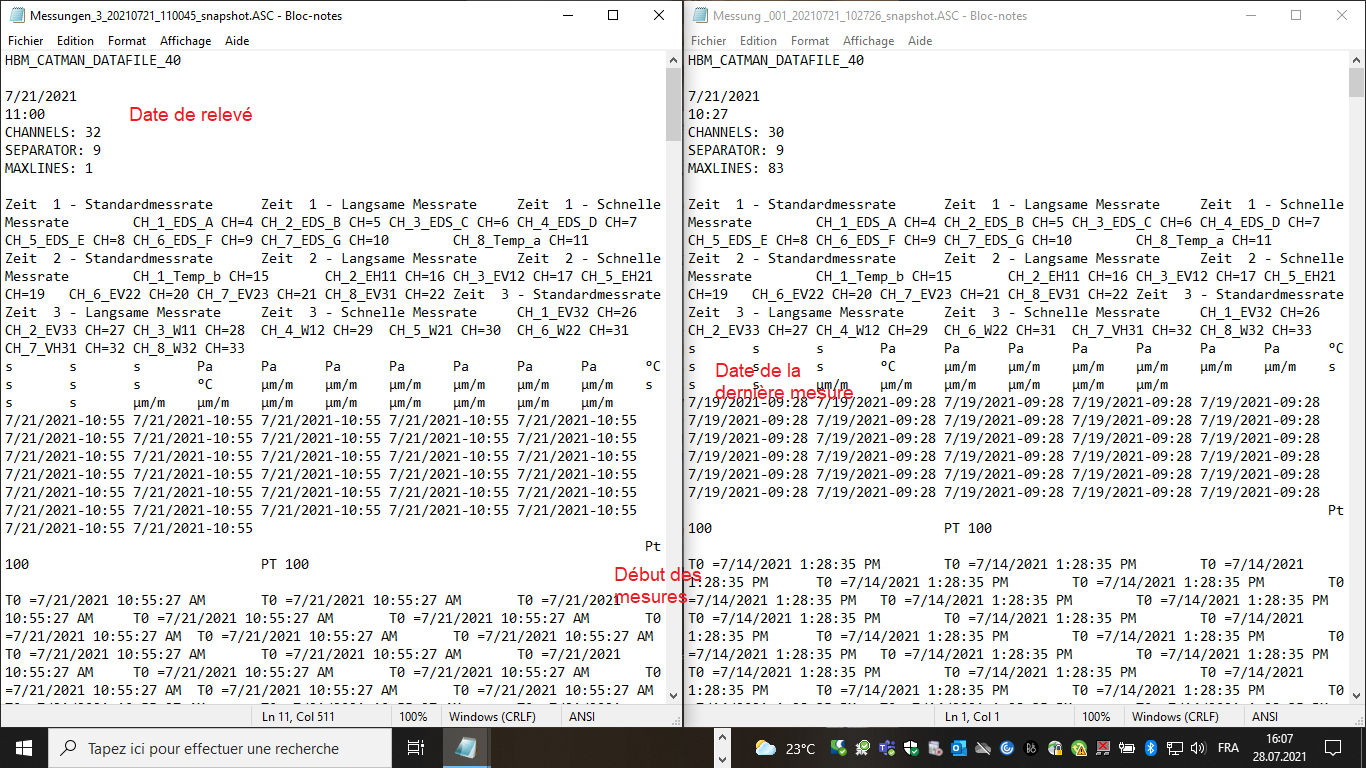

### Read files

#### Lecture des metadonnées et données

In [ ]:
#export
def __construct_INFO__(name_file):
  """
  Lit le fichier 'structure' et retourne la liste INFO
  """
  
  f_struc = open(name_file, "r")
  reader = csv.reader(f_struc, delimiter = '\t') 

  info = []       #Liste des info contenues dans le fichier permettera d'accéder aux données dans le ficher brut
  for row in reader:
    if len(row) >= 2:
      info.append(row[1])
    else:
      info.append("XXX")

  return info

In [ ]:
#export
def __construct_list_DATA__(name_file):
  """
  Lit un fichier '.asc' de mesures et retourne une liste image du fichier
  """
  
  f_csv = open(name_file, "r")
  reader = csv.reader(f_csv, delimiter = '\t')

  DATA = []    #Liste du fichier texte
  for row in reader:
    DATA.append(row)
  
  return DATA

#### Création des listes de données

In [ ]:
#export
def read_files(list_files_names, 
               structure_data):
  """
  Retourne le tuple des listes issues de la lecture des fichiers :
  - list_data : liste des listes images des fichiers de mesure 'messung_XX'
  - info : liste des informations contenues sur les premières lignes des fichiers de mesures
  """

  info = []
  list_data = []

  info = __construct_INFO__(structure_data)

  for file_name in list_files_names:
    list_data.append(__construct_list_DATA__(file_name))

  return list_data, info

In [ ]:
# example
DATA_TEST, INFO = read_files(TESTS_FILES_NAMES, STRUCTURE_DATA)

print("-------------------------------------")
print(INFO)
print(INFO.index('YYY'))
print("-------------------------------------")
print(DATA_TEST[0][0:10])
print(len(DATA_TEST))

-------------------------------------
['NAME', '', 'Date', 'Time', 'num_channels', 'XXX', 'num_messung', '', 'Name Channel', 'Units', 'Date - Hour', '', 'T0', 'Time Intervals', 'Num Channel', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'Units (Elektr.)', 'Units (Physik.)', 'XXX', 'XXX', 'XXX', '', 'XXX', 'Null', '', 'XXX', 'k Faktor', 'XXX', 'XXX', 'XXX', 'Type Sensor', 'ID Sensor', '', 'YYY']
37
-------------------------------------
[['HBM_CATMAN_DATAFILE_40'], [], ['7/14/2021'], ['11:07'], ['CHANNELS: 32'], ['SEPARATOR: 9'], ['MAXLINES: 34                 '], [], ['Zeit  1 - Standardmessrate', 'Zeit  1 - Langsame Messrate', 'Zeit  1 - Schnelle Messrate', 'CH_1_EDS_A CH=4', 'CH_2_EDS_B CH=5', 'CH_3_EDS_C CH=6', 'CH_4_EDS_D CH=7', 'CH_5_EDS_E CH=8', 'CH_6_EDS_F CH=9', 'CH_7_EDS_G CH=10', 'CH_8_Temp_a CH=11', 'Zeit  2 - Standardmessrate', 'Zeit  2 - Langsame Messrate', 'Zeit  2 - Schnelle Messrate', 'CH_1_Temp_b CH=15', 'CH_2_EH11 CH=16', 'CH_3_EV12 CH=17', 'CH_5_EH21 CH=19', 'CH_6_EV22 CH=20', 

 #### Tri des fichiers par ordre chronologique

In [ ]:
#export
def __dates_sorted__(list_data, info):
  """
  Construit un objet provisoire [(date.datetime, i_file)]
  """
  i_date = info.index('Date')
  dateFormatter = "%m/%d/%Y"

  dates = []

  for i_file in range(len(list_data)):
    file_data = list_data[i_file]
    dates_typ = datetime.strptime(file_data[2][0], dateFormatter)
    
    dates.append( (dates_typ , i_file) )

  dates_sorted = sorted(dates, key=lambda date: date[0])

  return dates_sorted

In [ ]:
# example
import random
random_list = random.sample(TESTS_FILES_NAMES, len(TESTS_FILES_NAMES))

DATA_TEST_TO_SORT, INFO = read_files(random_list, STRUCTURE_DATA) 
dates_sorted_test = __dates_sorted__(DATA_TEST_TO_SORT, INFO)

print("après tri")
for i in range(0,4):
  print(f"fichier {i}, date {dates_sorted_test[i][0]}")

après tri
fichier 0, date 2021-07-07 00:00:00
fichier 1, date 2021-07-14 00:00:00
fichier 2, date 2021-07-21 00:00:00
fichier 3, date 2021-07-28 00:00:00


In [ ]:
# test
for i in range(0,4):
  assert dates_sorted_test[i][0] == datetime(2021, 7, 7*(1+i), 0, 0, 0)

In [ ]:
dates_sorted_test[3][0]

datetime.datetime(2021, 7, 28, 0, 0)

In [ ]:
#export
def __ind_chrono_order__(dates_sorted):
  """
  Renvoie la liste des indices des fichiers dans l'ordre chronologique
  """
  ind_order = [elt[1] for elt in dates_sorted]

  return ind_order

In [ ]:
#export
def sort_chrono(list_data, info):
  dates_sorted = __dates_sorted__(list_data, info)
  i_new_order = __ind_chrono_order__(dates_sorted)

  new_list = []
  for i in i_new_order:
    new_list.append(list_data[i]) 

  return new_list

In [ ]:
# test
DATA_TEST_SORTED = sort_chrono(DATA_TEST_TO_SORT, INFO)

assert len(DATA_TEST) == len(DATA_TEST_SORTED)

# Vérification de l'ordre chronologique des fichiers tests
i_date = INFO.index('Date')
dateFormatter = "%m/%d/%Y"

dates = [datetime.strptime(file_test[i_date][0], dateFormatter) for file_test in DATA_TEST_SORTED]
dates_sorted = sorted(dates)

assert dates == dates_sorted , "Importation des fichiers qui ne respecte pas l'ordre chronologique"

assert len(DATA_TEST_SORTED) == 4
assert DATA_TEST_SORTED[1][2] == ['7/14/2021']
assert DATA_TEST_SORTED[2][2] == ['7/21/2021']
assert len(DATA_TEST_SORTED[1]) == 71

#### Traitement des listes images des fichiers
---
A partir de maintenant, les fonctions devront travailler avec les listes INFO et DATA/DATA_TEST, liste de listes images de fichiers afin de construire la base de données `df_messung`, fusion de toutes les valeurs expérimentales. \\
La liste DATA_TEST, sera utilisée comme objet, invariant, de test dans la validation des fonctions définies dans ce script.


##### Suppression des éléments vides 

On remarque que les fichiers générés peuvent présenter des élèments vides à la fin de chaque ligne. On implémente la fonction *__elements_vides__* qui permet de supprimer cet élèment.

In [ ]:
#export
# unit function

def __elements_vides__(data):
  """
  Supprime les élèments vides en dernière position
  """
  
  list_data = copy(data)     # Permet de ne pas modifier DATA

  for i_row in range(len(list_data)):
    row = list_data[i_row]

    if len(row) > 0:
      last_elt = row[-1]
      
      if last_elt == '':
        list_data[i_row] = row[:-1]

  return list_data

In [ ]:
#export
# global function

def traitement_elements_vides(data):
  """
  Permet d'appliquer la fonction __elements_vides__ à la liste DATA_MESSUNG
  """
  #Bricolage, mais la structure de DATA_MESSUNG fait que data[0][0] est 
  #la liste image du fichier est une chaine de caractère
  
  if data[0][0] == 'HBM_CATMAN_DATAFILE_40': 
    data = __elements_vides__(data)

  else: 
    for i in range(len(data)):
      data[i] = __elements_vides__(data[i])

  return data

In [ ]:
# test
# Le dernier élément est bien non vide

DATA_TEST2 = traitement_elements_vides(DATA_TEST)
for DATA in DATA_TEST2:
  assert DATA[-1] != '' , 'Vérifier le traitement des listes de mesures : un dernier élément est vide'

##### Lecture des paramètres des fichiers


In [ ]:
#export
def __condition_DATA__(file_data):
  """
  Teste si DATA est bien une liste image d'un fichier de mesures
  """

  if file_data[0][0] == 'HBM_CATMAN_DATAFILE_40': #Une meilleure condition pourra etre trouvée
    return True

  else: 
    return False

In [ ]:
#export
def list_names_channels(data_list, info):
  """
  Construction de la liste des noms des capteurs
  """
  assert __condition_DATA__(data_list), 'Fonction uniquement applicable à un fichier DATA'

  i_names_channels = info.index('Name Channel')
  names_channels = copy(data_list[i_names_channels])

  return names_channels

In [ ]:
# example
names_test_1 = list_names_channels(DATA_TEST[0], INFO)
print('Une liste de taille '+str(len(names_test_1))+', renvoyée par la fonction list_name_channels:')
print(names_test_1)

print('-------------------------')

names_test_2 = list_names_channels(DATA_TEST[1], INFO)
print('Une liste de taille '+str(len(names_test_2))+', renvoyée par la fonction list_name_channels:')
print(names_test_2)

Une liste de taille 32, renvoyée par la fonction list_name_channels:
['Zeit  1 - Standardmessrate', 'Zeit  1 - Langsame Messrate', 'Zeit  1 - Schnelle Messrate', 'CH_1_EDS_A CH=4', 'CH_2_EDS_B CH=5', 'CH_3_EDS_C CH=6', 'CH_4_EDS_D CH=7', 'CH_5_EDS_E CH=8', 'CH_6_EDS_F CH=9', 'CH_7_EDS_G CH=10', 'CH_8_Temp_a CH=11', 'Zeit  2 - Standardmessrate', 'Zeit  2 - Langsame Messrate', 'Zeit  2 - Schnelle Messrate', 'CH_1_Temp_b CH=15', 'CH_2_EH11 CH=16', 'CH_3_EV12 CH=17', 'CH_5_EH21 CH=19', 'CH_6_EV22 CH=20', 'CH_7_EV23 CH=21', 'CH_8_EV31 CH=22', 'Zeit  3 - Standardmessrate', 'Zeit  3 - Langsame Messrate', 'Zeit  3 - Schnelle Messrate', 'CH_1_EV32 CH=26', 'CH_2_EV33 CH=27', 'CH_3_VH11 CH=28', 'CH_4_W12 CH=29', 'CH_5_VH21 CH=30', 'CH_6_W22 CH=31', 'CH_7_VH31 CH=32', 'CH_8_W32 CH=33']
-------------------------
Une liste de taille 30, renvoyée par la fonction list_name_channels:
['Zeit  1 - Standardmessrate', 'Zeit  1 - Langsame Messrate', 'Zeit  1 - Schnelle Messrate', 'CH_1_EDS_A CH=4', 'CH_2_ED

In [ ]:
# test
assert len(names_test_1) == 32
assert len(names_test_2) == 30

#### Construction des bases de données

##### Extraction de T0

In [ ]:
#export
def extract_T0(file_data, info):
  """
  Renvoie un objet datatime
  """
  str_T0 = file_data[info.index('T0')][0]

  # Extraction des elements
  split_T0 = str_T0.split(' ')
  split_day = split_T0[1]
  
  day = split_day.split('=')[1]
  time = split_T0[2] + ' ' + split_T0[3]

  day_time = day + ' ' + time
  # Creation de l'objet datetime
  dateFormatter = "%m/%d/%Y %I:%M:%S %p"
  time = datetime.strptime(day_time, dateFormatter)
  
  return time

In [ ]:
# example
time_0 = extract_T0(DATA_TEST[0], INFO)
time_0

datetime.datetime(2021, 7, 7, 13, 24, 40)

In [ ]:
# test
assert str(time_0) == '2021-07-07 13:24:40'

##### Mise en forme base de données

La base de données *df_messung* conserve la structure initiale des fichiers de données importés. 

In [ ]:
#export
def construction_list_df_messung(data_messung,
                                 info):
  """
  Construit et renvoie la liste des DataFrame des séries de mesures en parcourant DATA_MESSUNG
  """
  #indices début des mesures
  i_mesures = info.index('YYY')
  
  # On vérifie que la partie commentaires de DATA_MESSUNG est de la meme taille
  assert len(data_messung[0][:i_mesures+1]) == len(info), "Mauvais fichier DATA_MESSUNG"


  num_tot_files = len(data_messung)
  list_df = []
  
  for num_file in range(num_tot_files):
    data_file = data_messung[num_file]
    names_channels = list_names_channels(data_file, info)

    #On récupère la partie comportant les mesures
    list_mesures = data_file[i_mesures:]
    
    #Creation de la base de données du ficher des mesures courantes
    df_num_file = pd.DataFrame(list_mesures, columns=names_channels) 
    
    # # #Colonnes paramètres de l'expérience
    # df_num_file['Serie de mesures'] = num_file

    # Colonne temps global
    time_0 = extract_T0(data_file, info)
    freq = df_num_file['Zeit  1 - Standardmessrate']

    times = [time_0 + timedelta(seconds=float(delta_t)) for delta_t in freq]
    df_num_file['date'] = times

    df_num_file.set_index('date',inplace = True)

    list_df.append(df_num_file)

  return list_df

In [ ]:
# example
list_df_test = construction_list_df_messung(DATA_TEST, INFO)
list_df_test[0].head(5)

,Zeit 1 - Standardmessrate,Zeit 1 - Langsame Messrate,Zeit 1 - Schnelle Messrate,CH_1_EDS_A CH=4,CH_2_EDS_B CH=5,CH_3_EDS_C CH=6,CH_4_EDS_D CH=7,CH_5_EDS_E CH=8,CH_6_EDS_F CH=9,CH_7_EDS_G CH=10,CH_8_Temp_a CH=11,Zeit 2 - Standardmessrate,Zeit 2 - Langsame Messrate,Zeit 2 - Schnelle Messrate,CH_1_Temp_b CH=15,CH_2_EH11 CH=16,CH_3_EV12 CH=17,CH_5_EH21 CH=19,CH_6_EV22 CH=20,CH_7_EV23 CH=21,CH_8_EV31 CH=22,Zeit 3 - Standardmessrate,Zeit 3 - Langsame Messrate,Zeit 3 - Schnelle Messrate,CH_1_EV32 CH=26,CH_2_EV33 CH=27,CH_3_VH11 CH=28,CH_4_W12 CH=29,CH_5_VH21 CH=30,CH_6_W22 CH=31,CH_7_VH31 CH=32,CH_8_W32 CH=33
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-07 13:24:40.200000,0.20000,0.00000,0.00000,-7820.88623,2159839.50000,-36016.18750,-1000000.00000,12439.58301,-6198071.00000,20038.04492,12.34039,0.20000,0.00000,0.00000,18.53559,4134.17676,3225.61426,5147.31592,4188.64844,4093.39478,4815.02637,0.20000,0.00000,0.00000,5773.70215,5584.22168,42620.19922,-722.19531,42329.48828,4414.75732,5715.32568,-23867.12109
2021-07-07 18:24:44.200860,18004.20086,0.00000,0.00000,183.08820,1934437.25000,-20862.70313,-1000000.00000,19554.00586,-6212432.00000,30181.69336,12.36769,18004.20086,0.00000,0.00000,18.45851,4181.61426,3266.91528,5185.42432,4285.81348,4040.43628,4915.27734,18004.20086,0.00000,0.00000,5816.59814,5630.43213,42619.35938,-651.42542,42328.15625,4460.56152,5758.48926,-21863.50781
2021-07-07 23:24:49.801710,36009.80171,0.00000,0.00000,-8862.40723,1705552.87500,-26351.51563,-1000000.00000,10957.18652,-6214493.00000,17809.27539,12.39935,36009.80171,0.00000,0.00000,18.38660,4136.41602,3212.33960,5134.05322,4262.81055,4086.04443,4900.20654,36009.80171,0.00000,0.00000,5769.34570,5585.88916,42619.10547,-663.36676,42327.73438,4403.73438,5698.95215,-20916.09375
2021-07-08 04:24:53.602570,54013.60257,0.00000,0.00000,-11061.33203,1723809.25000,-37397.53906,-1000000.00000,8057.57178,-6196865.50000,10307.86816,12.30714,54013.60257,0.00000,0.00000,18.27804,4133.56934,3200.20557,5122.53955,4282.81348,3923.59766,4913.66895,54013.60257,0.00000,0.00000,5762.69336,5581.84082,42620.73828,-562.71918,42329.94922,4391.29980,5688.71191,-20004.85742
2021-07-08 09:24:58.203420,72018.20342,0.00000,0.00000,-7851.06055,1962178.12500,-32658.68359,-1000000.00000,11167.24805,-6175929.50000,-58488.19141,12.36118,72018.20342,0.00000,0.00000,18.17512,4160.38379,3219.14209,5140.39600,4327.97412,3960.37500,4957.85449,72018.20342,0.00000,0.00000,5783.90527,5418.67871,42619.66406,-594.98596,42328.52734,4407.82715,5704.12207,-19211.96484


In [ ]:
# test
assert len(list_df_test) == 4

##### Fonction de concaténation

In [ ]:
#export
def concat_df_messung(list_df_messung_temp):
    df_concat = list_df_messung_temp[0]
    for df_serie in list_df_messung_temp[1:]:
        df_concat = pd.concat([df_concat, df_serie]) 

    return df_concat  

In [ ]:
# example
e = concat_df_messung(list_df_test)
e

,Zeit 1 - Standardmessrate,Zeit 1 - Langsame Messrate,Zeit 1 - Schnelle Messrate,CH_1_EDS_A CH=4,CH_2_EDS_B CH=5,CH_3_EDS_C CH=6,CH_4_EDS_D CH=7,CH_5_EDS_E CH=8,CH_6_EDS_F CH=9,CH_7_EDS_G CH=10,CH_8_Temp_a CH=11,Zeit 2 - Standardmessrate,Zeit 2 - Langsame Messrate,Zeit 2 - Schnelle Messrate,CH_1_Temp_b CH=15,CH_2_EH11 CH=16,CH_3_EV12 CH=17,CH_5_EH21 CH=19,CH_6_EV22 CH=20,CH_7_EV23 CH=21,CH_8_EV31 CH=22,Zeit 3 - Standardmessrate,Zeit 3 - Langsame Messrate,Zeit 3 - Schnelle Messrate,CH_1_EV32 CH=26,CH_2_EV33 CH=27,CH_3_VH11 CH=28,CH_4_W12 CH=29,CH_5_VH21 CH=30,CH_6_W22 CH=31,CH_7_VH31 CH=32,CH_8_W32 CH=33,CH_3_W11 CH=28,CH_5_W21 CH=30
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-07 13:24:40.200000,0.20000,0.00000,0.00000,-7820.88623,2159839.50000,-36016.18750,-1000000.00000,12439.58301,-6198071.00000,20038.04492,12.34039,0.20000,0.00000,0.00000,18.53559,4134.17676,3225.61426,5147.31592,4188.64844,4093.39478,4815.02637,0.20000,0.00000,0.00000,5773.70215,5584.22168,42620.19922,-722.19531,42329.48828,4414.75732,5715.32568,-23867.12109,NaN,NaN
2021-07-07 18:24:44.200860,18004.20086,0.00000,0.00000,183.08820,1934437.25000,-20862.70313,-1000000.00000,19554.00586,-6212432.00000,30181.69336,12.36769,18004.20086,0.00000,0.00000,18.45851,4181.61426,3266.91528,5185.42432,4285.81348,4040.43628,4915.27734,18004.20086,0.00000,0.00000,5816.59814,5630.43213,42619.35938,-651.42542,42328.15625,4460.56152,5758.48926,-21863.50781,NaN,NaN
2021-07-07 23:24:49.801710,36009.80171,0.00000,0.00000,-8862.40723,1705552.87500,-26351.51563,-1000000.00000,10957.18652,-6214493.00000,17809.27539,12.39935,36009.80171,0.00000,0.00000,18.38660,4136.41602,3212.33960,5134.05322,4262.81055,4086.04443,4900.20654,36009.80171,0.00000,0.00000,5769.34570,5585.88916,42619.10547,-663.36676,42327.73438,4403.73438,5698.95215,-20916.09375,NaN,NaN
2021-07-08 04:24:53.602570,54013.60257,0.00000,0.00000,-11061.33203,1723809.25000,-37397.53906,-1000000.00000,8057.57178,-6196865.50000,10307.86816,12.30714,54013.60257,0.00000,0.00000,18.27804,4133.56934,3200.20557,5122.53955,4282.81348,3923.59766,4913.66895,54013.60257,0.00000,0.00000,5762.69336,5581.84082,42620.73828,-562.71918,42329.94922,4391.29980,5688.71191,-20004.85742,NaN,NaN
2021-07-08 09:24:58.203420,72018.20342,0.00000,0.00000,-7851.06055,1962178.12500,-32658.68359,-1000000.00000,11167.24805,-6175929.50000,-58488.19141,12.36118,72018.20342,0.00000,0.00000,18.17512,4160.38379,3219.14209,5140.39600,4327.97412,3960.37500,4957.85449,72018.20342,0.00000,0.00000,5783.90527,5418.67871,42619.66406,-594.98596,42328.52734,4407.82715,5704.12207,-19211.96484,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-21 09:31:12.628050,590557.62805,0.00000,0.00000,6019.16211,4696151.00000,2525838.00000,-1000000.00000,-8412.96387,-6308409.50000,-4119381.75000,12.91957,590557.62805,0.00000,0.00000,18.29266,3936.26172,3023.85962,4561.40137,3577.23096,2983.59937,3111.21973,590557.62805,0.00000,0.00000,5053.70215,4838.98975,NaN,-544.87170,NaN,4005.80884,5208.85840,-8422.99219,NaN,NaN
2021-07-07 13:12:34.200000,0.20000,0.00000,0.00000,-7687.31982,2179665.50000,-35919.26172,-1000000.00000,12267.92676,-6197406.50000,19779.37305,12.34175,0.20000,0.00000,0.00000,18.53302,4134.35547,3225.95850,5147.64160,4188.68994,4093.42676,4811.99707,0.20000,0.00000,0.00000,5774.41162,5585.07813,42620.32031,-722.57202,42330.09766,4416.54932,5717.46777,-24011.49609,NaN,NaN
2021-07-07 13:17:34.200010,300.20001,0.00000,0.00000,-7719.16553,2169327.00000,-35989.06641,-1000000.00000,12339.29785,-6197624.50000,19827.28906,12.33900,300.20001,0.00000,0.00000,18.53399,4134.47461,3226.22339,5147.77295,4188.37012,4093.98071,4813.47412,300.20001,0.00000,0.00000,5774.04199,5584.95410,42620.19141,-723.65521,42329.81250,4415.53125,5715.90674,-23949.29297,NaN,NaN


##### Remove useless columns

In [ ]:
#export
def traitement_colonnes_zeit(df_messung):
  """
  Retire les colonnes inutlies de la df (Zeit)
  """

  for column_name in df_messung.columns:
    if 'Zeit' in column_name:
      del df_messung[column_name]

  return df_messung

In [ ]:
# example
print(e.columns)
t = traitement_colonnes_zeit(e)
print(t.columns)

Index(['Zeit  1 - Standardmessrate', 'Zeit  1 - Langsame Messrate',
       'Zeit  1 - Schnelle Messrate', 'CH_1_EDS_A CH=4', 'CH_2_EDS_B CH=5',
       'CH_3_EDS_C CH=6', 'CH_4_EDS_D CH=7', 'CH_5_EDS_E CH=8',
       'CH_6_EDS_F CH=9', 'CH_7_EDS_G CH=10', 'CH_8_Temp_a CH=11',
       'Zeit  2 - Standardmessrate', 'Zeit  2 - Langsame Messrate',
       'Zeit  2 - Schnelle Messrate', 'CH_1_Temp_b CH=15', 'CH_2_EH11 CH=16',
       'CH_3_EV12 CH=17', 'CH_5_EH21 CH=19', 'CH_6_EV22 CH=20',
       'CH_7_EV23 CH=21', 'CH_8_EV31 CH=22', 'Zeit  3 - Standardmessrate',
       'Zeit  3 - Langsame Messrate', 'Zeit  3 - Schnelle Messrate',
       'CH_1_EV32 CH=26', 'CH_2_EV33 CH=27', 'CH_3_VH11 CH=28',
       'CH_4_W12 CH=29', 'CH_5_VH21 CH=30', 'CH_6_W22 CH=31',
       'CH_7_VH31 CH=32', 'CH_8_W32 CH=33', 'CH_3_W11 CH=28',
       'CH_5_W21 CH=30'],
      dtype='object')
Index(['CH_1_EDS_A CH=4', 'CH_2_EDS_B CH=5', 'CH_3_EDS_C CH=6',
       'CH_4_EDS_D CH=7', 'CH_5_EDS_E CH=8', 'CH_6_EDS_F CH=9',
       

In [ ]:
# test
assert len(t.columns) == 25

##### Rename columns

On souhaite à présent mettre les noms des colonnes sous la forme `NAME_SENSOR`. Cela permettra, ensuite, de faire les liens avec les états de branchements - via le numéro de channel - ainsi qu'avec la disposition des capteurs - via leurs noms. 



In [ ]:
#export
def __clean_name__(name_column_CH):
  """
  Argument : string de la forme CH_Y_SENSOR_INDICE  CH=Z
  Renvoie la string CH_Y
  """

  assert type(name_column_CH) == str
  assert 'CH' in name_column_CH
  
  new_name = ''

  splited_name = name_column_CH.split(' ')
  CH_Y_SENSOR_INDICE = splited_name[0] #Drop de CH=Z
  dropped_part = splited_name[1]

  if 'CH' in dropped_part:
    SENSOR_INDICE = CH_Y_SENSOR_INDICE[5:]
    
    new_name = SENSOR_INDICE
  
  else :
    return name_column_CH #La string a déja été traitée

  return new_name

In [ ]:
# test
assert __clean_name__('CH_1_EDS_A CH=4') == 'EDS_A'

In [ ]:
#export
def traitement_colonnes_names(df_messung):
  """
  Renomme les colonnes pour afficher le nom des capteurs
  """
  new_names = []

  for column_name in df_messung.columns:
    if 'CH' in column_name:
      new_name = __clean_name__(column_name)
      new_names.append(new_name)

    else:
      new_names.append(column_name)

  df_messung.columns = new_names

  return df_messung

In [ ]:
# example
print(t.columns)
t = traitement_colonnes_names(t)
print(t.columns)

Index(['CH_1_EDS_A CH=4', 'CH_2_EDS_B CH=5', 'CH_3_EDS_C CH=6',
       'CH_4_EDS_D CH=7', 'CH_5_EDS_E CH=8', 'CH_6_EDS_F CH=9',
       'CH_7_EDS_G CH=10', 'CH_8_Temp_a CH=11', 'CH_1_Temp_b CH=15',
       'CH_2_EH11 CH=16', 'CH_3_EV12 CH=17', 'CH_5_EH21 CH=19',
       'CH_6_EV22 CH=20', 'CH_7_EV23 CH=21', 'CH_8_EV31 CH=22',
       'CH_1_EV32 CH=26', 'CH_2_EV33 CH=27', 'CH_3_VH11 CH=28',
       'CH_4_W12 CH=29', 'CH_5_VH21 CH=30', 'CH_6_W22 CH=31',
       'CH_7_VH31 CH=32', 'CH_8_W32 CH=33', 'CH_3_W11 CH=28',
       'CH_5_W21 CH=30'],
      dtype='object')
Index(['EDS_A', 'EDS_B', 'EDS_C', 'EDS_D', 'EDS_E', 'EDS_F', 'EDS_G', 'Temp_a',
       'Temp_b', 'EH11', 'EV12', 'EH21', 'EV22', 'EV23', 'EV31', 'EV32',
       'EV33', 'VH11', 'W12', 'VH21', 'W22', 'VH31', 'W32', 'W11', 'W21'],
      dtype='object')


In [ ]:
# test
assert numpy.all(t.columns == ['EDS_A', 'EDS_B', 'EDS_C', 'EDS_D', 'EDS_E', 'EDS_F', 'EDS_G', 'Temp_a',
       'Temp_b', 'EH11', 'EV12', 'EH21', 'EV22', 'EV23', 'EV31', 'EV32',
       'EV33', 'VH11', 'W12', 'VH21', 'W22', 'VH31', 'W32', 'W11', 'W21'])

#####  Buggs on column names
Buggs am 27.08.21

In [ ]:
assert 'EH13' not in t.columns # should be in CH_4_EH13 on the second Station

assert 'EV31' in t.columns # it should be 'EH31'

# Sensor B has been switched with sensor B2 from 25.08.2021

In [ ]:
#export
def patch_buggs_in_column_names(df, date_of_switch_sensor_B):

  # CH_4_EH13 is missing on the second Station
  #TODO

  #'EV31' in t.columns but it should be 'EH31'
  df = df.rename(columns={'EV31': 'EH31'})

  # Sensor B has been switched with sensor B2 from 25.05.2021
  df['EDS_B2'] = df['EDS_B']
  df.loc[df.index < date_of_switch_sensor_B, "EDS_B2"] = np.nan
  df.loc[df.index >= date_of_switch_sensor_B, "EDS_B"] = np.nan


  return df

In [ ]:
# example
e = t
e = patch_buggs_in_column_names(t, '2021-07-15')
e[['EDS_B2', 'EDS_B']]

,EDS_B2,EDS_B
date,,
2021-07-07 13:24:40.200000,NaN,2159839.50000
2021-07-07 18:24:44.200860,NaN,1934437.25000
2021-07-07 23:24:49.801710,NaN,1705552.87500
2021-07-08 04:24:53.602570,NaN,1723809.25000
2021-07-08 09:24:58.203420,NaN,1962178.12500
...,...,...
2021-07-21 09:31:12.628050,4696151.00000,NaN
2021-07-07 13:12:34.200000,NaN,2179665.50000
2021-07-07 13:17:34.200010,NaN,2169327.00000


In [ ]:
# test
t2 = patch_buggs_in_column_names(t, '2021-07-15')

assert 'EH31' in t2.columns
assert 'EV31' not in t2.columns

assert 'EDS_B'in t2.columns
assert 'EDS_B2'in t2.columns


assert t2.loc[t2.index < '2021-07-15', "EDS_B2"].isnull().all()
assert t2.loc[t2.index >= '2021-07-15', "EDS_B"].isnull().all()


#TODO
# assert 'EH13' in t.columns

#### Clean values

##### Convert columns into float

In [ ]:
type(t['EDS_A'][0])

str

In [ ]:
#export
def conversion_float(df):
  """
  Transforme les éléments en float
  """
  for column_name in df.columns:
    df[column_name] = df[column_name].astype(float)
    
  return df

In [ ]:
# example
t = conversion_float(t)
t.dtypes

EDS_A     float64
EDS_B     float64
EDS_C     float64
EDS_D     float64
EDS_E     float64
EDS_F     float64
EDS_G     float64
Temp_a    float64
Temp_b    float64
EH11      float64
EV12      float64
EH21      float64
EV22      float64
EV23      float64
EV31      float64
EV32      float64
EV33      float64
VH11      float64
W12       float64
VH21      float64
W22       float64
VH31      float64
W32       float64
W11       float64
W21       float64
dtype: object

In [ ]:
# test
import pandas.api.types as ptypes

assert all(ptypes.is_numeric_dtype(t[col]) for col in t.columns)

##### Change -1000000.0 into nan

In [ ]:
#export
def change_overhead_values(df):
  df = df.replace(-1000000.0, np.nan)
  return df

In [ ]:
# example
t1 = t.loc[:,t.columns.str.startswith('EDS_D')].sample(2, random_state=0)
print(t1)

t2 = change_overhead_values(t1)
print(t2)

                                EDS_D
date                                 
2021-07-15 17:29:02.204790 -1000000.0
2021-07-19 13:30:29.620520 -1000000.0
                            EDS_D
date                             
2021-07-15 17:29:02.204790    NaN
2021-07-19 13:30:29.620520    NaN


In [ ]:
# test
assert t['EDS_D'].values[0] == -1000000.0
assert pd.isna(t2['EDS_D'].values[0])

##### Downsampling data to T = 1 day

In [ ]:
#export
def downsample(df):
  return df.resample('d').mean()

In [ ]:
# example
t = t.sort_index()
t1 = downsample(t)

# EDS
fig = go.Figure()


for name_column in t.columns:
  if 'CH' and 'EDS' in name_column and 'EDS_D' not in name_column:
    fig.add_trace(
        go.Scatter(x=t.index, y=t[name_column], 
                   name=name_column, 
                   mode='lines+markers', 
                   marker_size=3
                   )
        )
    
    fig.add_trace(
        go.Scatter(x=t1.index, y=t1[name_column], 
                   name=name_column, 
                   mode='markers', 
                   marker_size=7
                   )
        )

# Mise en page
fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=30),
    title='Evolution des valeurs brutes - EDS',
    xaxis_title="Date",
    yaxis_title="Valeur [10^6]",
    title_font=dict(family="Rockwell", size=18)
)

fig.show()

In [ ]:
# test
assert t.shape == (121, 25)
assert t1.shape == (22, 25)

#### Get automatic data

In [ ]:
#export
def get_automatic_data(list_files_names,
                       structure_data
                       ):
  """
  Fonction merge DATA --> df_finale
  """
  # Creation des listes images des fichiers
  list_files_names, info = read_files(list_files_names, structure_data)

  list_files_names = sort_chrono(list_files_names, info)
  
  # Suppression des éléments vides
  list_files_names = traitement_elements_vides(list_files_names)

  # Construction de la liste des df
  list_df_messung = construction_list_df_messung(list_files_names, info)

  # Concatenation des df
  df_messung = concat_df_messung(list_df_messung)

  # Mise en forme des colonnes 
  df_messung = traitement_colonnes_zeit(df_messung)
  df_messung = traitement_colonnes_names(df_messung)
  df_messung = conversion_float(df_messung)

  # clear bugg
  df_messung = patch_buggs_in_column_names(df_messung, '2021-08-25')

  # clean
  df_messung = conversion_float(df_messung)
  df_messung = change_overhead_values(df_messung)
  df_messung = downsample(df_messung)


  return df_messung

In [ ]:
# example
df = get_automatic_data(list_files_names=TESTS_FILES_NAMES,
                        structure_data=STRUCTURE_DATA)
df

,EDS_A,EDS_B,EDS_C,EDS_D,EDS_E,EDS_F,EDS_G,Temp_a,Temp_b,EH11,EV12,EH21,EV22,EV23,EH31,EV32,EV33,VH11,W12,VH21,W22,VH31,W32,W11,W21,EDS_B2
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-07,-6381.338122,2.029764e+06,-3.102775e+04,NaN,1.351160e+04,-6.204005e+06,2.152714e+04,12.357636,18.489542,4144.207424,3231.410206,5152.441602,4222.866506,4081.456592,4851.196288,5781.619920,5594.115040,42619.835158,-696.642944,42329.057814,4422.226758,5721.228320,-22921.502342,NaN,NaN,NaN
2021-07-08,-6762.034912,2.172570e+06,-3.205732e+04,NaN,1.211302e+04,-6.179858e+06,-2.343901e+04,12.318925,18.114148,7164.830448,6773.002015,7164.428222,5556.738770,5303.325685,7963.350588,6809.185667,8777.449707,42620.191405,146.433290,42329.265625,7886.359617,9163.963745,-16133.623778,NaN,NaN,NaN
2021-07-09,-2018.012598,3.480844e+06,-4.431066e+04,NaN,1.225305e+04,-6.144872e+06,7.606129e+05,13.246442,17.389582,14486.567970,16234.105862,12245.913672,8678.272266,8948.771484,15904.031444,9518.866994,15991.103906,42620.296874,6237.198230,42329.163282,17489.710546,18430.485548,-13388.209766,NaN,NaN,NaN
2021-07-10,935.770994,5.028151e+06,-3.860611e+04,NaN,1.089357e+04,-6.123807e+06,3.463341e+06,13.552458,17.327794,15308.895898,16459.754102,12041.971680,8467.745314,8774.810744,16026.174220,9515.263868,16711.291796,42620.873438,14922.061328,42330.146096,17553.987108,18612.746876,-10094.402346,NaN,NaN,NaN
2021-07-11,-2397.739064,4.736352e+06,-3.446018e+04,NaN,5.556870e+03,-6.089783e+06,5.486970e+06,13.274016,17.700372,15841.093554,16961.544532,12288.182812,8587.216992,8921.753322,16648.441798,9533.143556,17905.341018,42620.439066,15742.709570,42329.439846,18226.669140,19220.331252,-9309.595704,NaN,NaN,NaN
2021-07-12,2242.589478,5.255263e+06,8.988906e+04,NaN,7.240887e+03,-6.078723e+06,5.736801e+06,13.096946,17.867130,16135.622268,17605.227344,12356.037694,8551.872464,8982.269532,16800.033986,9550.777342,18268.235548,42620.926562,16130.842382,42330.121094,18628.412892,19752.859768,-8927.376954,NaN,NaN,NaN
2021-07-13,-16260.717775,3.421834e+06,4.952766e+05,NaN,-1.967319e+04,-6.048677e+06,5.130718e+06,13.809313,17.903382,16257.342040,17463.093260,12465.821777,8512.331545,9050.593260,16655.736815,9474.620118,18468.692873,42620.334962,16349.865965,42329.291995,18673.627930,19717.474608,-8495.704835,NaN,NaN,NaN
2021-07-14,-7074.942002,6.092999e+05,1.528713e+06,NaN,-1.532733e+04,-6.331498e+06,1.574850e+06,14.520733,17.041056,7766.861736,7599.983343,7056.769587,5065.813800,5144.839680,8104.185954,6539.104709,9116.722874,42619.678390,6646.751167,42328.345053,8655.639351,9869.340496,-16945.393553,NaN,NaN,NaN
2021-07-15,-5904.092943,4.193187e+05,2.106431e+06,NaN,-9.169845e+03,-6.333763e+06,-1.489162e+06,14.475628,16.775894,3816.102722,2898.297587,4597.279460,3586.462607,3384.617207,4262.001669,5094.316652,4887.976604,NaN,1954.556833,NaN,3967.265218,5172.394979,-19002.141114,NaN,NaN,NaN


## Manual measures

#### Test file

In [ ]:
# Test files
TEST_HAND = './test/df_hand_test.csv'

In [ ]:
df_hand = pd.read_csv(TEST_HAND, delimiter=';')  
df_hand

,date,EH12,EH13,EH22,EH23,EH32,EH33,EV11,EV21,EV31,VH12,VH13,VH22,VH23,VH32,VH33,W11,W13,W21,W23,W31,W33
0,07.07.2021,NaN,-3763.0,-6972,NaN,-5550.0,-5922,-4817,NaN,-6131.0,-4319,-3196,-4515,-3309.0,-3690,-5518,-3205.0,-4123,-4000.0,-4489.0,NaN,-5335
1,14.07.2021,NaN,-3540.0,-6531,NaN,-5116.0,-5224,-4501,NaN,-5668.0,-4040,-2720,-4046,NaN,-3198,-5097,-3395.0,-3871,-3561.0,-3533.0,NaN,-4751
2,21.07.2021,NaN,NaN,-6620,-5090.0,NaN,-5513,-4670,NaN,-5671.0,-4198,-2872,-4110,NaN,-3165,-5094,-3556.0,-4029,-3539.0,NaN,NaN,-4647
3,28.07.2021,NaN,NaN,-6407,NaN,-4910.0,-5415,-4631,NaN,-5546.0,-4140,-2925,-3981,NaN,-3050,-4907,NaN,-3994,NaN,NaN,NaN,-4491
4,05.08.2021,NaN,NaN,-6422,NaN,-4897.0,-5412,-4662,NaN,-5543.0,-4126,-2924,-3975,NaN,-3100,-4939,NaN,-4047,NaN,-3224.0,NaN,-4467
5,11.08.2021,NaN,NaN,-6485,NaN,-4922.0,-5430,-4804,NaN,-5584.0,-4316,-3003,-4073,NaN,-2577,-5021,NaN,-4119,NaN,-3282.0,NaN,-4521
6,18.08.2021,NaN,NaN,-6408,NaN,-4904.0,-5420,-4828,NaN,NaN,-4390,-2989,-4282,NaN,-3140,-4485,NaN,-4109,NaN,-3276.0,NaN,-4505


### Functions

In [ ]:
#export
def define_index(df):
  df_time = copy(df)

  if 'date' in df.columns:

    df_time['Datetime'] = pd.to_datetime(df_time['date'], format='%d.%m.%Y')
    df_time = df_time.set_index('Datetime')
    df_time = df_time.drop(['date'], 1)

  return df_time

In [ ]:
# example
df_hand = define_index(df_hand)
df_hand

,EH12,EH13,EH22,EH23,EH32,EH33,EV11,EV21,EV31,VH12,VH13,VH22,VH23,VH32,VH33,W11,W13,W21,W23,W31,W33
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-07-07,NaN,-3763.0,-6972,NaN,-5550.0,-5922,-4817,NaN,-6131.0,-4319,-3196,-4515,-3309.0,-3690,-5518,-3205.0,-4123,-4000.0,-4489.0,NaN,-5335
2021-07-14,NaN,-3540.0,-6531,NaN,-5116.0,-5224,-4501,NaN,-5668.0,-4040,-2720,-4046,NaN,-3198,-5097,-3395.0,-3871,-3561.0,-3533.0,NaN,-4751
2021-07-21,NaN,NaN,-6620,-5090.0,NaN,-5513,-4670,NaN,-5671.0,-4198,-2872,-4110,NaN,-3165,-5094,-3556.0,-4029,-3539.0,NaN,NaN,-4647
2021-07-28,NaN,NaN,-6407,NaN,-4910.0,-5415,-4631,NaN,-5546.0,-4140,-2925,-3981,NaN,-3050,-4907,NaN,-3994,NaN,NaN,NaN,-4491
2021-08-05,NaN,NaN,-6422,NaN,-4897.0,-5412,-4662,NaN,-5543.0,-4126,-2924,-3975,NaN,-3100,-4939,NaN,-4047,NaN,-3224.0,NaN,-4467
2021-08-11,NaN,NaN,-6485,NaN,-4922.0,-5430,-4804,NaN,-5584.0,-4316,-3003,-4073,NaN,-2577,-5021,NaN,-4119,NaN,-3282.0,NaN,-4521
2021-08-18,NaN,NaN,-6408,NaN,-4904.0,-5420,-4828,NaN,NaN,-4390,-2989,-4282,NaN,-3140,-4485,NaN,-4109,NaN,-3276.0,NaN,-4505


In [ ]:
# test
df_hand.index[0]

Timestamp('2021-07-07 00:00:00')

In [ ]:
#export
def get_manual_data(file_name):

  #Lecture du fichier CSV
  df_hand = pd.read_csv(file_name, delimiter=';')  

  #Creation de l'index date
  df_hand = define_index(df_hand)

  # defined for automatic values
  df_hand = conversion_float(df_hand)
  
  return df_hand

In [ ]:
# example 
df = get_manual_data(TEST_HAND)
df

,EH12,EH13,EH22,EH23,EH32,EH33,EV11,EV21,EV31,VH12,VH13,VH22,VH23,VH32,VH33,W11,W13,W21,W23,W31,W33
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-07-07,NaN,-3763.0,-6972.0,NaN,-5550.0,-5922.0,-4817.0,NaN,-6131.0,-4319.0,-3196.0,-4515.0,-3309.0,-3690.0,-5518.0,-3205.0,-4123.0,-4000.0,-4489.0,NaN,-5335.0
2021-07-14,NaN,-3540.0,-6531.0,NaN,-5116.0,-5224.0,-4501.0,NaN,-5668.0,-4040.0,-2720.0,-4046.0,NaN,-3198.0,-5097.0,-3395.0,-3871.0,-3561.0,-3533.0,NaN,-4751.0
2021-07-21,NaN,NaN,-6620.0,-5090.0,NaN,-5513.0,-4670.0,NaN,-5671.0,-4198.0,-2872.0,-4110.0,NaN,-3165.0,-5094.0,-3556.0,-4029.0,-3539.0,NaN,NaN,-4647.0
2021-07-28,NaN,NaN,-6407.0,NaN,-4910.0,-5415.0,-4631.0,NaN,-5546.0,-4140.0,-2925.0,-3981.0,NaN,-3050.0,-4907.0,NaN,-3994.0,NaN,NaN,NaN,-4491.0
2021-08-05,NaN,NaN,-6422.0,NaN,-4897.0,-5412.0,-4662.0,NaN,-5543.0,-4126.0,-2924.0,-3975.0,NaN,-3100.0,-4939.0,NaN,-4047.0,NaN,-3224.0,NaN,-4467.0
2021-08-11,NaN,NaN,-6485.0,NaN,-4922.0,-5430.0,-4804.0,NaN,-5584.0,-4316.0,-3003.0,-4073.0,NaN,-2577.0,-5021.0,NaN,-4119.0,NaN,-3282.0,NaN,-4521.0
2021-08-18,NaN,NaN,-6408.0,NaN,-4904.0,-5420.0,-4828.0,NaN,NaN,-4390.0,-2989.0,-4282.0,NaN,-3140.0,-4485.0,NaN,-4109.0,NaN,-3276.0,NaN,-4505.0


In [ ]:
# test
assert df.dtypes[0] == 'float64'

## Merge automatic and manual measures

### Clean

##### Change units

In [ ]:
# export
def df_to_m(df):
  df_m = copy(df)

  for name_column in df_m.columns:
    if 'Temp' not in name_column:
      df_m[name_column] = df_m[name_column] / 1e6

  return df_m

In [ ]:
# example
df_m_test = df_to_m(df)
df_m_test

,EH12,EH13,EH22,EH23,EH32,EH33,EV11,EV21,EV31,VH12,VH13,VH22,VH23,VH32,VH33,W11,W13,W21,W23,W31,W33
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-07-07,NaN,-0.003763,-0.006972,NaN,-0.005550,-0.005922,-0.004817,NaN,-0.006131,-0.004319,-0.003196,-0.004515,-0.003309,-0.003690,-0.005518,-0.003205,-0.004123,-0.004000,-0.004489,NaN,-0.005335
2021-07-14,NaN,-0.003540,-0.006531,NaN,-0.005116,-0.005224,-0.004501,NaN,-0.005668,-0.004040,-0.002720,-0.004046,NaN,-0.003198,-0.005097,-0.003395,-0.003871,-0.003561,-0.003533,NaN,-0.004751
2021-07-21,NaN,NaN,-0.006620,-0.00509,NaN,-0.005513,-0.004670,NaN,-0.005671,-0.004198,-0.002872,-0.004110,NaN,-0.003165,-0.005094,-0.003556,-0.004029,-0.003539,NaN,NaN,-0.004647
2021-07-28,NaN,NaN,-0.006407,NaN,-0.004910,-0.005415,-0.004631,NaN,-0.005546,-0.004140,-0.002925,-0.003981,NaN,-0.003050,-0.004907,NaN,-0.003994,NaN,NaN,NaN,-0.004491
2021-08-05,NaN,NaN,-0.006422,NaN,-0.004897,-0.005412,-0.004662,NaN,-0.005543,-0.004126,-0.002924,-0.003975,NaN,-0.003100,-0.004939,NaN,-0.004047,NaN,-0.003224,NaN,-0.004467
2021-08-11,NaN,NaN,-0.006485,NaN,-0.004922,-0.005430,-0.004804,NaN,-0.005584,-0.004316,-0.003003,-0.004073,NaN,-0.002577,-0.005021,NaN,-0.004119,NaN,-0.003282,NaN,-0.004521
2021-08-18,NaN,NaN,-0.006408,NaN,-0.004904,-0.005420,-0.004828,NaN,NaN,-0.004390,-0.002989,-0.004282,NaN,-0.003140,-0.004485,NaN,-0.004109,NaN,-0.003276,NaN,-0.004505


### Merge

In [ ]:
#export
def get_data(list_files_names,
             structure_data,
             file_name_df_hand,
             ):
  """
  Fonction merge DATA --> df_finale
  """
  # Get automatic data
  df_automatic = get_automatic_data(list_files_names, structure_data)

  # Get manual data
  df_hand = get_manual_data(file_name_df_hand)

  # Merge
  ## fill na to avoid getting new columns
  for col in ['W11', 'W21']:
    df_automatic[col].fillna(df_hand[col], inplace=True)
    df_hand.drop(columns=col, inplace=True)

  ## merge
  df_messung = pd.merge(df_hand, df_automatic, left_index=True, right_index=True, how='outer')

  #df_messung = pd.concat([df_automatic, df_hand])

  # Change units
  df_messung = df_to_m(df_messung)

  # Sort values
  df_messung = df_messung.sort_index()

  return df_messung

In [ ]:
# example
df_compu_test = get_data(list_files_names=TESTS_FILES_NAMES,
                         structure_data=STRUCTURE_DATA, 
                         file_name_df_hand=TEST_HAND)
df_compu_test

,EH12,EH13,EH22,EH23,EH32,EH33,EV11,EV21,EV31,VH12,VH13,VH22,VH23,VH32,VH33,W13,W23,W31,W33,EDS_A,EDS_B,EDS_C,EDS_D,EDS_E,EDS_F,EDS_G,Temp_a,Temp_b,EH11,EV12,EH21,EV22,EV23,EH31,EV32,EV33,VH11,W12,VH21,W22,VH31,W32,W11,W21,EDS_B2
2021-07-07,NaN,-0.003763,-0.006972,NaN,-0.005550,-0.005922,-0.004817,NaN,-0.006131,-0.004319,-0.003196,-0.004515,-0.003309,-0.003690,-0.005518,-0.004123,-0.004489,NaN,-0.005335,-0.006381,2.029764,-0.031028,NaN,0.013512,-6.204005,0.021527,12.357636,18.489542,0.004144,0.003231,0.005152,0.004223,0.004081,0.004851,0.005782,0.005594,0.042620,-0.000697,0.042329,0.004422,0.005721,-0.022922,-0.003205,-0.004000,NaN
2021-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006762,2.172570,-0.032057,NaN,0.012113,-6.179858,-0.023439,12.318925,18.114148,0.007165,0.006773,0.007164,0.005557,0.005303,0.007963,0.006809,0.008777,0.042620,0.000146,0.042329,0.007886,0.009164,-0.016134,NaN,NaN,NaN
2021-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002018,3.480844,-0.044311,NaN,0.012253,-6.144872,0.760613,13.246442,17.389582,0.014487,0.016234,0.012246,0.008678,0.008949,0.015904,0.009519,0.015991,0.042620,0.006237,0.042329,0.017490,0.018430,-0.013388,NaN,NaN,NaN
2021-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000936,5.028151,-0.038606,NaN,0.010894,-6.123807,3.463341,13.552458,17.327794,0.015309,0.016460,0.012042,0.008468,0.008775,0.016026,0.009515,0.016711,0.042621,0.014922,0.042330,0.017554,0.018613,-0.010094,NaN,NaN,NaN
2021-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002398,4.736352,-0.034460,NaN,0.005557,-6.089783,5.486969,13.274016,17.700372,0.015841,0.016962,0.012288,0.008587,0.008922,0.016648,0.009533,0.017905,0.042620,0.015743,0.042329,0.018227,0.019220,-0.009310,NaN,NaN,NaN
2021-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002243,5.255263,0.089889,NaN,0.007241,-6.078723,5.736801,13.096946,17.867130,0.016136,0.017605,0.012356,0.008552,0.008982,0.016800,0.009551,0.018268,0.042621,0.016131,0.042330,0.018628,0.019753,-0.008927,NaN,NaN,NaN
2021-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016261,3.421834,0.495277,NaN,-0.019673,-6.048677,5.130718,13.809313,17.903382,0.016257,0.017463,0.012466,0.008512,0.009051,0.016656,0.009475,0.018469,0.042620,0.016350,0.042329,0.018674,0.019717,-0.008496,NaN,NaN,NaN
2021-07-14,NaN,-0.003540,-0.006531,NaN,-0.005116,-0.005224,-0.004501,NaN,-0.005668,-0.004040,-0.002720,-0.004046,NaN,-0.003198,-0.005097,-0.003871,-0.003533,NaN,-0.004751,-0.007075,0.609300,1.528713,NaN,-0.015327,-6.331498,1.574850,14.520733,17.041056,0.007767,0.007600,0.007057,0.005066,0.005145,0.008104,0.006539,0.009117,0.042620,0.006647,0.042328,0.008656,0.009869,-0.016945,-0.003395,-0.003561,NaN
2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005904,0.419319,2.106431,NaN,-0.009170,-6.333763,-1.489162,14.475628,16.775894,0.003816,0.002898,0.004597,0.003586,0.003385,0.004262,0.005094,0.004888,NaN,0.001955,NaN,0.003967,0.005172,-0.019002,NaN,NaN,NaN
2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000332,0.675779,2.315424,NaN,-0.005186,-6.334882,-2.319801,14.548817,16.596679,0.003843,0.002941,0.004606,0.003634,0.003385,0.004381,0.005099,0.004903,NaN,0.001984,NaN,0.003989,0.005228,-0.016058,NaN,NaN,NaN


In [ ]:
# test
assert df_compu_test.index.is_unique

assert ['_x' not in col for col in df_compu_test.columns]

assert df_compu_test.dtypes[0] == numpy.float64

assert len(df_compu_test) == 25


# Check of data

This check is made out of the library just to explore data. 
Figures can be further transformed into library to serve as dashboard somewhere on a "core" notebook.

## Input data

### Import production files


In [ ]:
#test_flag_colab
import os
path = '/content/drive/MyDrive/spundsteif/data'
imported_rawdata = os.listdir(path)
imported_rawdata

['1_messung_00_datum_07_07_2021.txt',
 '1_messung_01_datum_14_07_2021.ASC',
 '1_messung_02_datum_21_07_2021.txt',
 '1_messung_03_20210728_104137_snapshot.ASC',
 '1_messung_04_20210728_111821_snapshot.ASC',
 '1_messung_04_20210805_095433_snapshot.ASC',
 '1_messung_05_20210811_101121_snapshot.ASC',
 '1_messung_06_20210818_100618_snapshot.ASC',
 '1_structure_file.txt',
 'df_hand.csv',
 'df_proprietes.csv',
 'df_rawdata_inklino.csv']

In [ ]:
#test_flag_colab
MESSUNG_FILES_NAMES = [path + '/' + elt for elt in imported_rawdata if 'messung' in elt]
STRUCTURE_DATA = path + '/' + '1_structure_file.txt'
HAND_DATA = path + '/' +'df_hand.csv'

### Create production database

In [ ]:
%%time
#test_flag_colab
df_messung = get_data(list_files_names=MESSUNG_FILES_NAMES,
                      structure_data=STRUCTURE_DATA, 
                      file_name_df_hand=HAND_DATA)

df_messung

CPU times: user 132 ms, sys: 3.65 ms, total: 136 ms
Wall time: 144 ms


## Visualize data

### Temporal evolution

#### EDS

In [ ]:
#test_flag_colab

# EDS
fig = go.Figure()
date = df_messung.index

for name_column in df_messung.columns:
  if 'CH' and 'EDS' in name_column:
    fig.add_trace(
        go.Scatter(x=date, y=df_messung[name_column], 
                   name=name_column, 
                   mode='lines+markers', 
                   marker_size=3
        )
    )

# Mise en page
fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=30),
    title='Evolution des valeurs brutes - EDS',
    xaxis_title="Date",
    yaxis_title="Valeur [10^6]",
    title_font=dict(family="Rockwell", size=18)
)

fig.show()

#### DMS

In [ ]:
#test_flag_colab

#DMS 
fig = go.Figure()
time = df_messung.index

for name_column in df_messung.columns:
  if 'EDS' not in name_column and 'Temp' not in name_column:
    fig.add_trace(
        go.Scatter(x=time, y=df_messung[name_column], 
                   name=name_column, 
                   mode='lines+markers',
                   marker=dict(size=3)
                   )
    )

# Mise en page
fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=30),
    title='Evolution des mesures brutes - DMS',
    title_font=dict(family="Rockwell", size=18),
    xaxis_title="Date",
    yaxis_title="Valeur [10^6]",
    # legend_title='test',
)

fig.show()

#### Temperature

In [ ]:
#test_flag_colab

# Températures
fig = go.Figure()
time = df_messung.index

for name_column in df_messung.columns:
  if 'Temp' in name_column:
    fig.add_trace(
        go.Scatter(x=time, y=df_messung[name_column], 
                   name=name_column,
                   mode='lines+markers',
                   marker=dict(size=3)
                   )
    )
fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=30),
    title='Evolution des mesures brutes - Température',
    title_font=dict(family="Rockwell", size=18),
    xaxis_title="Date",
    yaxis_title="Température [°]",
)

fig.show()

#  
---

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 01_sensors.ipynb.
Converted 02_inclinometers.ipynb.
Converted 03_pressures.ipynb.
Converted index.ipynb.
